# Spectral fitting 
Demonstration of how to fit a spectrum for the example described in `response_demo.ipynb` where an instrument response was generated for a simple toy detector.

We will look at two different methods for comparison, both using [Stan](https://mc-stan.org).

In [1]:
import numpy as np
import h5py
import stan_utility
import corner
from matplotlib import pyplot as plt
from instrument_response.detector import Response

/Users/fran/projects/bayes/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


We have some data detected by our toy detector. We think it comes from a power law (this is our model), and under this assumption, we want to fit for the normalisation, $N$, and spectral index, $\alpha$, of this model (the parameters). In order to compare our model with data, we will use the response generated in `response_demo.ipynb`.

In [46]:
# Load response
response_file = 'output/response_sim.h5'
with h5py.File(response_file, 'r') as f:
    initial_energy = f['initial_energy'].value
    true_energy = f['true_energy'].value
    detected_energy = f['detected_energy'].value
    effective_area_max = f['effective_area_maximum'].value
response = Response(initial_energy, true_energy, detected_energy, effective_area_max, 
                    nbins_true_energy=100, nbins_detected_energy=50)

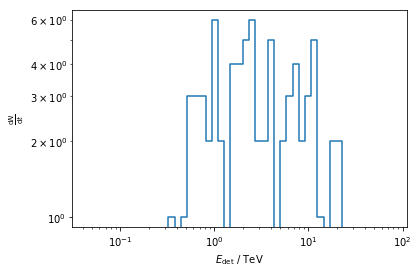

In [47]:
# Have a look at the data 
data_file = 'output/data.h5'

with h5py.File(data_file, 'r') as f:
    detected_energy = f['detected_energy'].value

dN_dt, _ = np.histogram(detected_energy, bins=response.detected_energy_bins)

fig, ax = plt.subplots()
ax.step(response.detected_energy_bins[:-1], dN_dt, where='pre')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('$E_\mathrm{det}$ / TeV')
ax.set_ylabel(r'$\frac{\mathrm{d}N}{\mathrm{d}t}$');

## Standard approach
For this simple fitting example, we can fold our model spectrum through the instrument response to compare with the data in the fit, as described in `response_demo.ipynb`. We will use the Hamiltonian Monte Carlo approach implemented in `Stan` to determine which model parameters best describe our data.

The likelihood is:
$$
p(n | \alpha, N) = \prod_{i=1}^{N_{\rm{bins}}} \frac{s_i^{n_i}e^{-s_i}}{n_i!},
$$

where $s_i$ are the expected counts in each energy bin (or *channel*), computed by folding the model through the repsonse, and $n_i$ are the actual observed counts in each bin.

In [4]:
# Compile the Stan model
model = stan_utility.compile_model(filename='stan/standard_approach.stan', 
                                   model_name='standard')

Using cached StanModel


In [5]:
# Run the fit
fit_input = {}
fit_input['Nbins_true'] = response.nbins_true_energy
fit_input['Nbins_detected'] = response.nbins_detected_energy
fit_input['min_energy'] = 1 # TeV
fit_input['max_energy'] = 100 # TeV
fit_input['n'] = dN_dt
fit_input['response_matrix'] = response.matrix
fit_input['true_energy_bins'] = response.true_energy_bins
fit_input['detected_energy_bins'] = response.detected_energy_bins

fit = model.sampling(data=fit_input, iter=1000, chains=4)
# Warnings below just because some channels have zero counts...

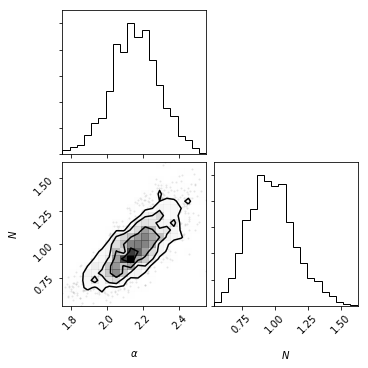

In [6]:
# View fit parameters
chain = fit.extract(permuted=True)
key_list = ['alpha', 'N']
labels = [r'$\alpha$', '$N$']
#truths = [2.0, 0.9236320123663313]

corner.corner(np.column_stack([chain[key] for key in key_list]),
              labels=labels); #, truths=truths);

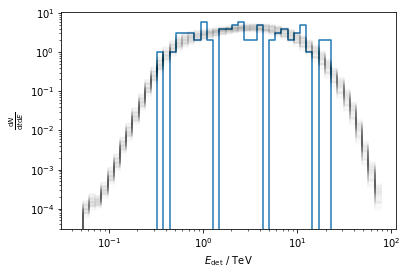

In [7]:
# Look at samples of folded model counts in data space
fig, ax = plt.subplots()
ax.step(response.detected_energy_bins[:-1], fit_input['n'], where='pre')
for i in range(100):
    ax.step(response.detected_energy_bins[:-1], chain['s'][i], 
            where='pre', color='k', alpha = 0.01)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('$E_\mathrm{det}$ / TeV')
ax.set_ylabel(r'$\frac{\mathrm{d}N}{\mathrm{d}t\mathrm{d}E}$');

## Hierarchical approach

Another way to think about this could be to model each particle/photon from production to detection. In this way, each particle/photon would have latent *true* energies inferred from their detected energies. 


This time, instead of the response matrix used above, we now want a related quantity, the probability distribution of $P(E_{\rm{det}} | E_{\rm{true}})$ which will form part of the hierarchical likelihood. Our data will also now be just the detected energies for each event registered in the detector. 

The likelihood is as follows:
$$
P(E_{\rm{det}} | \alpha, N) = e^{-\bar{N}_{\rm{events}}}\prod_{i=1}^{N_{\rm{events}}} 
P({\rm{detected}} | E_{\rm{true}})P(E_{\rm{det}}^i | E_{\rm{true}}^i) P(E_{\rm{true}}^i | \alpha, N),
$$

where $\bar{N}_{\rm{events}} = \int {\rm{d}}E \ A_{\rm{eff}}(E) \frac{{\rm{d}}N}{{\rm{d}}E{\rm{d}}t{\rm{d}}A}$. We can get the conditional probability distribution $P(E_{\rm{det}} | E_{\rm{true}})$ and the $A_{\rm{eff}}(E)$ from the same information used to construct the response matrix.

/Users/fran/projects/bayes/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.


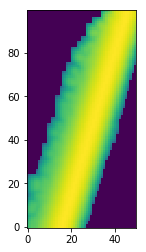

In [221]:
from scipy.ndimage import gaussian_filter
p_det_given_true = response.p_detected_given_true
p_smooth = gaussian_filter(p_det_given_true, (np.log(3), np.log(3)))
log_p_smooth = np.log(p_smooth)
log_p_smooth[log_p_smooth < -35] = -36
plt.imshow(log_p_smooth, origin='lower')

# normalise 
#p_smooth = np.exp(log_p_smooth) / sum((sum(np.exp(log_p_smooth))))
#sum(sum(p_smooth))
#log_p_smooth = np.log(p_smooth)

In [222]:
# Fit a spline to P_Edet_given_Etrue
from scipy.interpolate import RectBivariateSpline
# get bin centres
def get_centres(bins):
    return bins[:-1] + (bins[1:]-bins[:-1])/2
true_centres = get_centres(response.true_energy_bins)
detected_centres = get_centres(response.detected_energy_bins)

spline = RectBivariateSpline(true_centres, 
                             detected_centres, 
                             log_p_smooth, s=0.0)

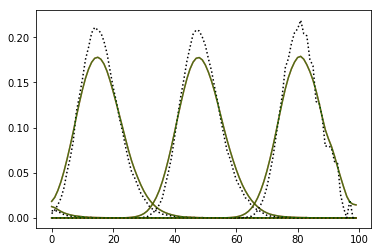

In [223]:
fig, ax = plt.subplots()
for i in [10, 20, 30, 40]:
    ax.plot(p_smooth.T[i], color = 'r', alpha = 0.7)
    ax.plot(p_det_given_true.T[i], color = 'k', linestyle=':')
    ax.plot([np.exp(spline(_, detected_centres[i])[0][0]) for _ in true_centres],
            color='g', alpha = 0.7)

However, we will need to interpolate over this shape in Stan. This can be made easier by fitting a spline to the function and evaluating this from the knots and coefficients
.

In [224]:
# Get knots and coefficients for input to Stan
p = 3 # spline degree
knots = spline.get_knots()
xknots = np.unique(knots[0])
yknots = np.unique(knots[1])
Nx = len(xknots)+p-1
Ny = len(yknots)+p-1 
coeffs = spline.get_coeffs()
coeffs = coeffs.reshape(Nx, Ny)

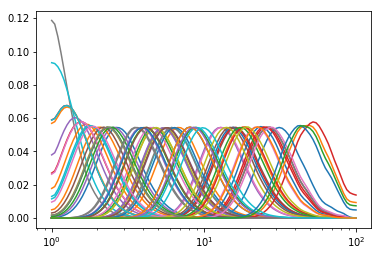

In [225]:
# 1D interpolation to compare
# get the dists for each Edet
Egrid = np.logspace(np.log(1.0), np.log(100.0), response.nbins_true_energy, base=np.e)

cond_prob_n = []
for i, Edet in enumerate(detected_energy):
    cond_prob = np.exp([spline(_, Edet)[0][0] for _ in Egrid])
    #cond_prob_n.append(cond_prob)
    cond_prob_n.append(cond_prob / sum(cond_prob))
    plt.plot(Egrid, cond_prob_n[i])
plt.xscale('log')

In [281]:
# Compile the Stan model
model = stan_utility.compile_model(filename='stan/hierarchical_approach.stan', 
                                   model_name='hierarchical', include_paths='stan/')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL hierarchical_f9a7d1e9ef9161360ec10b9123cb8326 NOW.


In [284]:
fit_input = {}
fit_input['Nevents'] = len(detected_energy)
fit_input['Edet'] = detected_energy
fit_input['min_energy'] = 1.0 # TeV
fit_input['max_energy'] = 100.0 # TeV
fit_input['p'] = p
fit_input['Lknots_x'] = len(xknots)
fit_input['Lknots_y'] = len(yknots)
fit_input['xknots'] = xknots
fit_input['yknots'] = yknots
fit_input['c'] = coeffs
fit_input['Ngrid'] = response.nbins_true_energy
fit_input['Etrue_grid'] = Egrid
fit_input['cond_prob'] = np.log(cond_prob_n)

fit = model.sampling(data=fit_input, iter=1000, chains=4)

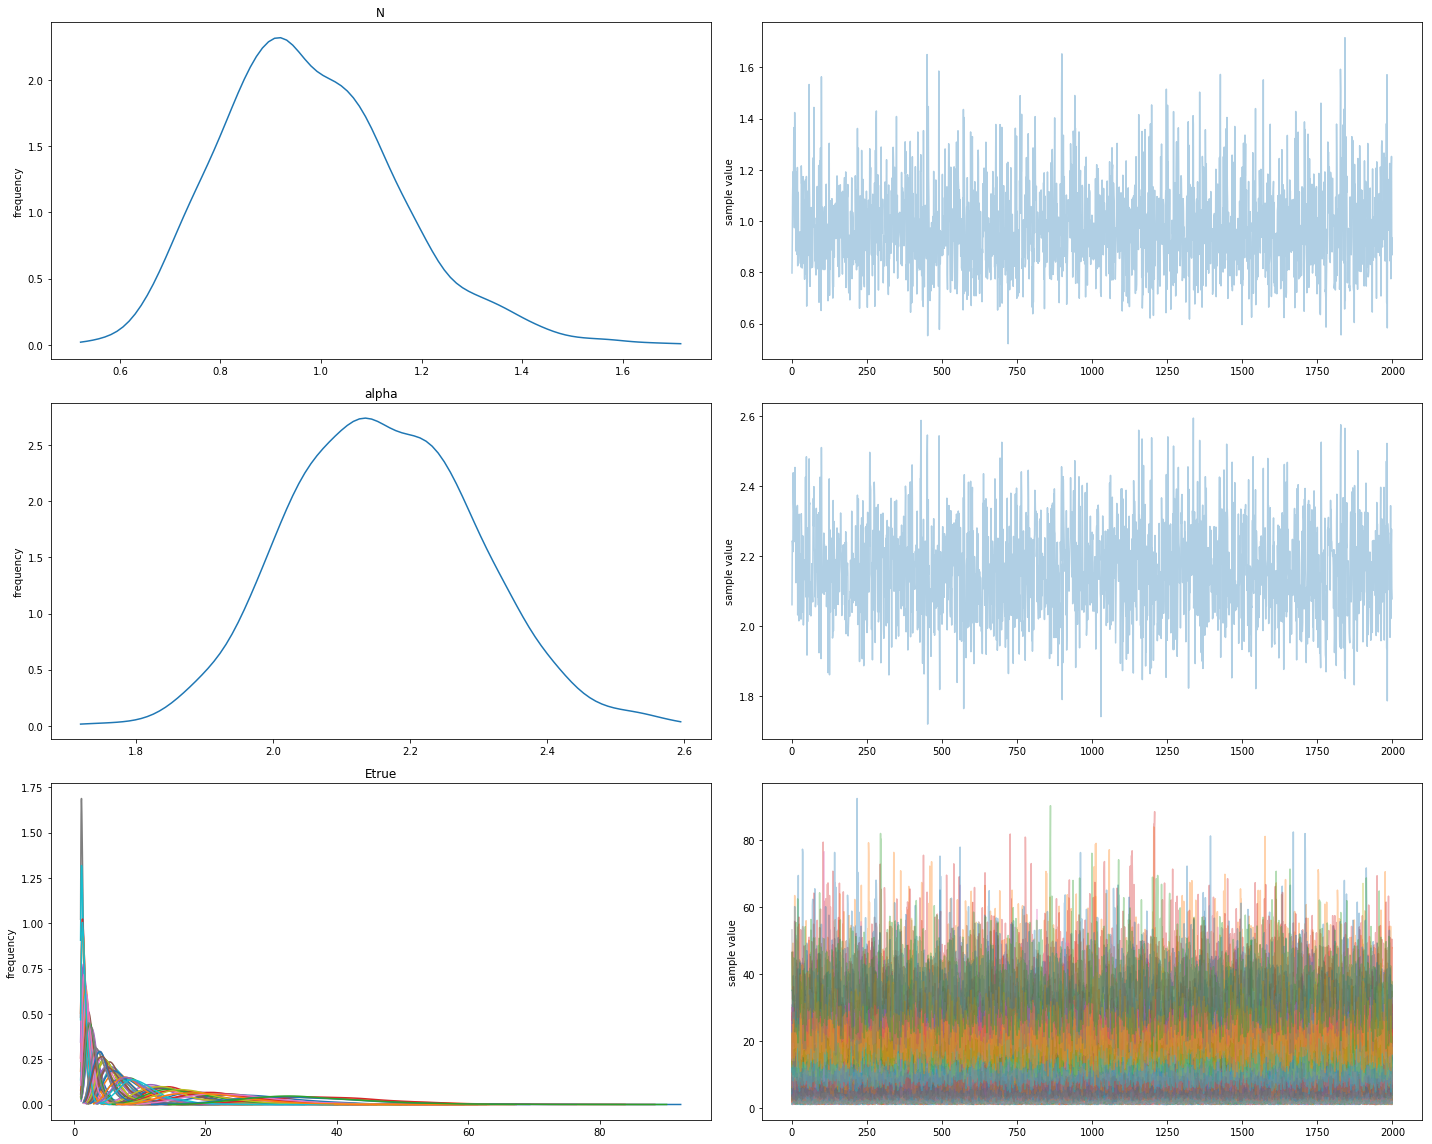

In [285]:
fig = fit.plot(['N', 'alpha', 'Etrue']);
fig.set_size_inches(20, 16)
fig.tight_layout()

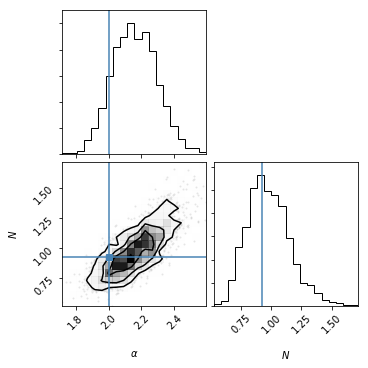

In [286]:
# View fit parameters
chain = fit.extract(permuted=True)
key_list = ['alpha', 'N']
labels = [r'$\alpha$', '$N$']
truths = [2.0, 0.9236320123663313]

corner.corner(np.column_stack([chain[key] for key in key_list]),
              labels=labels, truths=truths);

## Testing spline

In [ ]:
# Compile the Stan model
model = stan_utility.compile_model(filename='stan/testing.stan', 
                                   model_name='testing', include_paths='stan/')

In [ ]:
xvals = np.logspace(np.log(min(xknots)), np.log(max(xknots)), base=np.e)
yvals = np.logspace(np.log(min(yknots)), np.log(max(yknots)), base=np.e)

In [ ]:
fit_input['p'] = p
fit_input['Lknots_x'] = len(xknots)
fit_input['Lknots_y'] = len(yknots)
fit_input['xknots'] = xknots
fit_input['yknots'] = yknots
fit_input['c'] = coeffs
fit_input['Nevals'] = 50
fit_input['xvals'] = xvals
fit_input['yvals'] = yvals

output = model.sampling(data = fit_input, iter=1, chains=1, 
                          algorithm="Fixed_param")

In [ ]:
zvals = output.extract(['zvals'])['zvals'][0]
log_zvals = output.extract(['log_zvals'])['log_zvals'][0]
plt.imshow(log_zvals, origin='lower')

In [ ]:
for i in range(50):
    for j in range(50):
        if np.isnan(log_zvals[i][j]):
            print('NaN!')

In [ ]:
xknots